In [94]:
# Data preparation
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re

# Load the dataset
dataframe = pd.read_csv('cleaned.csv')

# Exclude the unnecessary columns
columns_to_exclude = ['label', 'url', 'ssl_issuer', 'ssl_subject', 'ssl_not_before', 'ssl_not_after', 'domain']
X = dataframe.drop(columns=columns_to_exclude)
y = dataframe['label']

# Function to extract RGBA values (with default alpha = 0 if missing)
def extract_rgba(color):
    rgba_values = re.findall(r'\d+\.?\d*', color)  # This captures both integers and floats
    if len(rgba_values) == 3:  # If only RGB is present, default alpha (A) to 0
        rgba_values.append('0')
    return int(rgba_values[0]), int(rgba_values[1]), int(rgba_values[2]), float(rgba_values[3])

# Function to convert RGBA values to hex string (alpha scaled to [0, 255])
def rgba_to_hex(r, g, b, a):
    return f'{int(r):02x}{int(g):02x}{int(b):02x}{int(a * 255):02x}'  # Alpha scaled from [0, 1] to [0, 255]

# Apply the function to extract RGBA components and convert to hex
if 'background_color' in X.columns:
    X[['r', 'g', 'b', 'a']] = X['background_color'].apply(lambda x: pd.Series(extract_rgba(x)))
    # Convert rgba to hex
    X['color_hex'] = X.apply(lambda row: rgba_to_hex(row['r'], row['g'], row['b'], row['a']), axis=1)
    # Drop the individual r, g, b, a columns
    X = X.drop(columns=['r', 'g', 'b', 'a', 'background_color'])

# Convert non-numeric columns in X to numeric using label encoding (excluding rgba columns)
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object' and column not in ['color_hex']:
        # Handle 'most_used_font_face' encoding while ignoring values wrapped in quotes
        if column == 'most_used_font_face':
            # Strip quotes from font face values and handle missing values
            X[column] = X[column].apply(lambda x: x.strip('"') if isinstance(x, str) else '')  # Check if it's a string first
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))  # Encode the column
        label_encoders[column] = le

# Label encode the 'color_hex' column
if 'color_hex' in X.columns:
    le = LabelEncoder()
    X['color_hex_encoded'] = le.fit_transform(X['color_hex'].astype(str))
    X = X.drop(columns=['color_hex'])  # Drop the original hex color column after encoding
    
if 'indexing_status' in X.columns:
    le = LabelEncoder()
    X['indexing_status_encoded'] = le.fit_transform(X['indexing_status'].astype(str))
    X = X.drop(columns=['indexing_status']) 

# Convert target variable y to numeric using label encoding if necessary
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y.astype(str))

# Keep the URL column for printing purposes, but exclude it from the analysis
X['url'] = dataframe['url']
X_for_analysis = X.drop(columns=['url'])  # Drop the URL column for analysis


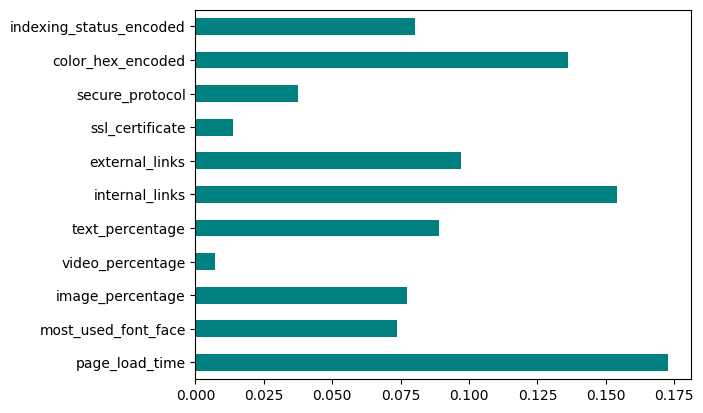

In [43]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt


importances = mutual_info_classif(X_for_analysis, y)
feat_importances = pd.Series(importances, X_for_analysis.columns)
feat_importances.plot(kind='barh', color='teal')
plt.show()

In [44]:
X.to_csv('data_prepared.csv', index=False)

In [45]:
#Chi-square Test

from sklearn.feature_selection import SelectKBest, chi2

X_cat = X_for_analysis.astype(int)
chi2_features = SelectKBest(chi2, k=8)
X_kbest_features = chi2_features.fit_transform(X_cat, y)

print('Original feature number:', X_cat.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])
print('Selected features:', X_cat.columns[chi2_features.get_support()])

Original feature number: 11
Reduced feature number: 8
Selected features: Index(['page_load_time', 'most_used_font_face', 'image_percentage',
       'text_percentage', 'internal_links', 'external_links',
       'color_hex_encoded', 'indexing_status_encoded'],
      dtype='object')


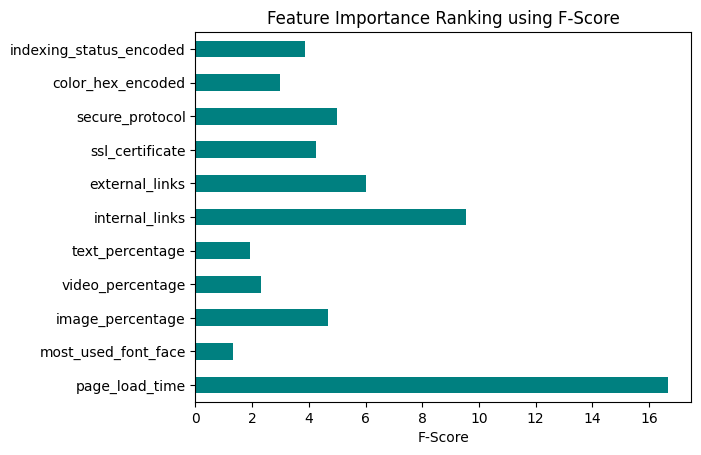

In [46]:
#Fisher’s Score
# Import necessary libraries
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Assuming X_for_analysis and y have already been prepared as per the previous code

# Apply SelectKBest with f_classif (ANOVA F-value, similar to Fisher’s Score)
selector = SelectKBest(score_func=f_classif, k='all')  # Set k='all' to score all features
X_new = selector.fit_transform(X_for_analysis, y)

# Get the scores
ranks = selector.scores_

# Convert to a Pandas Series for easy plotting
feat_importances = pd.Series(ranks, X_for_analysis.columns)

# Plot the feature importances
feat_importances.plot(kind='barh', color='teal')
plt.xlabel('F-Score')
plt.title('Feature Importance Ranking using F-Score')
plt.show()


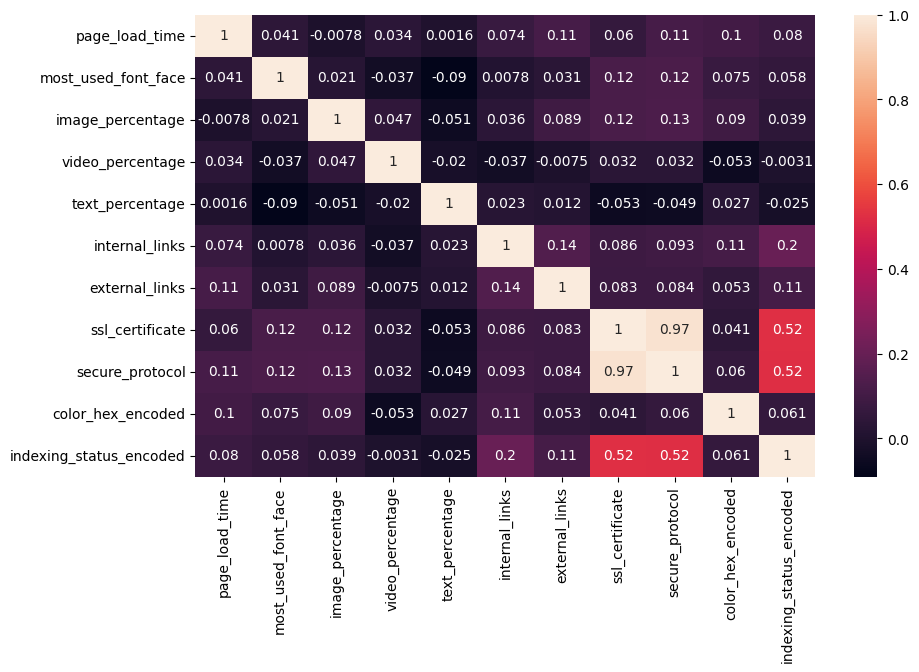

In [47]:
#Correlation Coefficient

import seaborn as sns

# Correlation matrix
cor = X_for_analysis.corr()

# Plotting Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cor, annot=True)
plt.show()

In [48]:
from sklearn.feature_selection import VarianceThreshold

v_threshold = VarianceThreshold(threshold=0)
v_threshold.fit(X_for_analysis)
support = v_threshold.get_support()
print(support)

selected_features = X_for_analysis.columns[support]
print('Selected features:', selected_features)

[ True  True  True  True  True  True  True  True  True  True  True]
Selected features: Index(['page_load_time', 'most_used_font_face', 'image_percentage',
       'video_percentage', 'text_percentage', 'internal_links',
       'external_links', 'ssl_certificate', 'secure_protocol',
       'color_hex_encoded', 'indexing_status_encoded'],
      dtype='object')


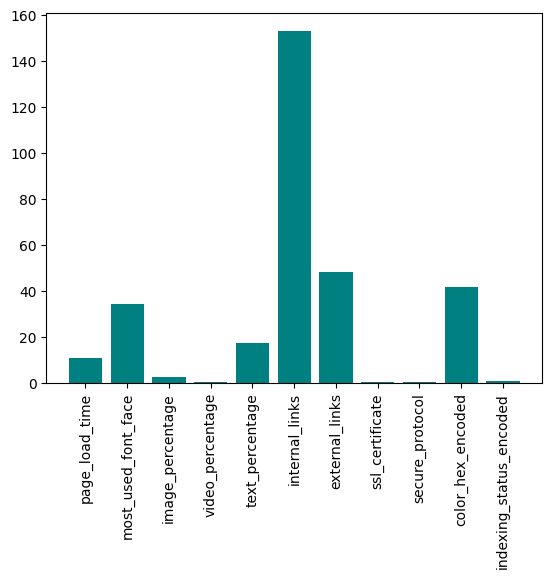

In [49]:
# Mean Absolute Difference (MAD)

import numpy as np

mean_abs_diff = np.sum(np.abs(X_for_analysis - np.mean(X_for_analysis, axis=0)), axis=0) / X_for_analysis.shape[0]

# Plot the barchart
plt.bar(np.arange(X_for_analysis.shape[1]), mean_abs_diff, color='teal')
plt.xticks(np.arange(X_for_analysis.shape[1]), X_for_analysis.columns, rotation=90)
plt.show()


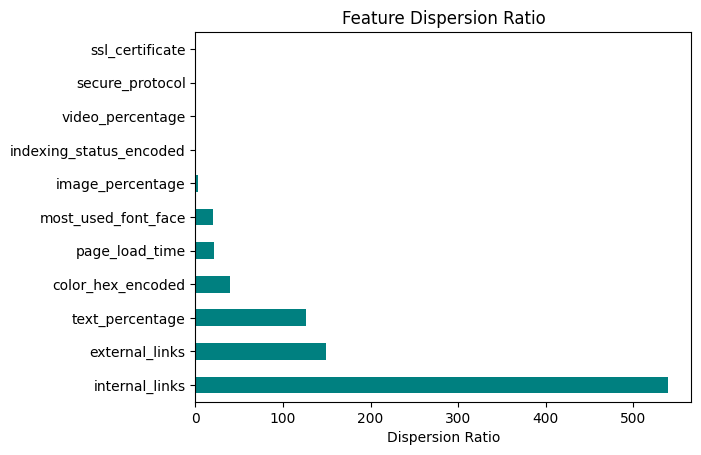

In [50]:
# Dispersion Ratio
dispersion_ratio = X_for_analysis.var() / X_for_analysis.mean()
dispersion_ratio = dispersion_ratio.replace([np.inf, -np.inf], np.nan).dropna()  # Handle any infinite values
dispersion_ratio.sort_values(ascending=False).plot(kind='barh', color='teal')
plt.xlabel('Dispersion Ratio')
plt.title('Feature Dispersion Ratio')
plt.show()


Original feature number: 11
Reduced feature number: 5
Selected features: ['page_load_time', 'image_percentage', 'text_percentage', 'internal_links', 'secure_protocol']


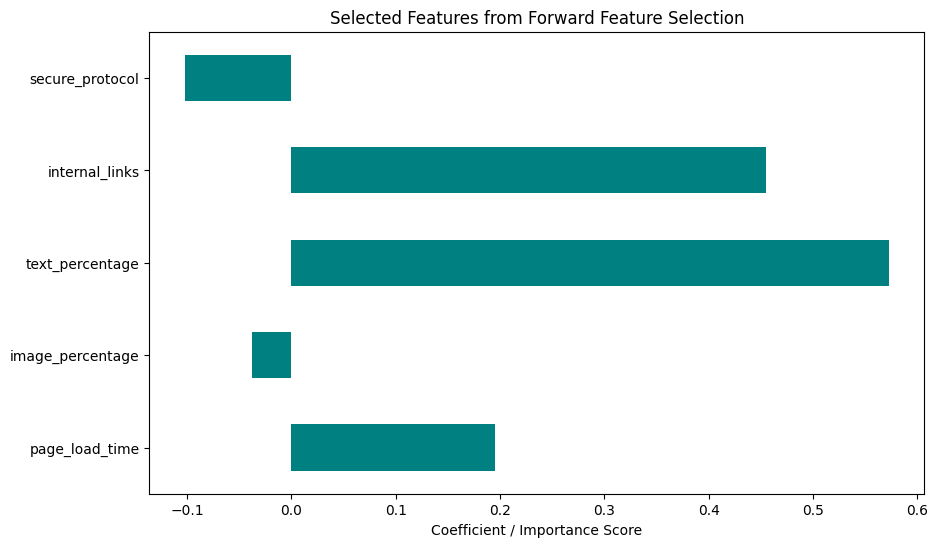

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_analysis)

# Initialize the model with increased max_iter
model = LogisticRegression(max_iter=1000)

# Forward feature selection
selector = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward')
selector.fit(X_scaled, y)

# Get selected feature indices
selected_mask = selector.get_support()
selected_features = X_for_analysis.columns[selected_mask]

# Print original and reduced feature numbers
print(f"Original feature number: {X_for_analysis.shape[1]}")
print(f"Reduced feature number: {len(selected_features)}")
print("Selected features:", selected_features.tolist())

# Fit the model again to get the coefficients for the selected features
model.fit(X_scaled[:, selected_mask], y)

# Create a Series for the selected features with their respective coefficients
selected_feature_scores = pd.Series(model.coef_[0], index=selected_features)

# Plot selected features and their scores
plt.figure(figsize=(10, 6))
selected_feature_scores.plot(kind='barh', color='teal')
plt.xlabel('Coefficient / Importance Score')
plt.title('Selected Features from Forward Feature Selection')
plt.show()




In [52]:
from sklearn.feature_selection import RFE

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Backward Feature Elimination
selector = RFE(model, n_features_to_select=8, step=1)
selector.fit(X_scaled, y)

# Get selected feature indices
selected_mask = selector.support_
selected_features = X_for_analysis.columns[selected_mask]

# Print selected features
print("Selected features (Backward Feature Elimination):", selected_features.tolist())


Selected features (Backward Feature Elimination): ['page_load_time', 'image_percentage', 'video_percentage', 'text_percentage', 'internal_links', 'external_links', 'secure_protocol', 'color_hex_encoded']


In [53]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming the data has already been loaded and processed
# X_for_analysis and y should already be defined

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_analysis)

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Exhaustive Feature Selection
exhaustive_selector = ExhaustiveFeatureSelector(model,
                                                n_jobs=-1,
                                                scoring='accuracy',
                                                print_progress=True,
                                                cv=5)
exhaustive_selector.fit(X_scaled, y)

# Get selected feature indices
selected_mask = exhaustive_selector.best_idx_
selected_features = X_for_analysis.columns[list(selected_mask)]

# Print selected features
print("Selected features (Exhaustive Feature Selection):", selected_features.tolist())





Features: 11/11

Selected features (Exhaustive Feature Selection): ['page_load_time']


In [54]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
model = DecisionTreeClassifier()

# Recursive Feature Elimination
rfe_selector = RFE(model, n_features_to_select=5)  # Set the number of features you want to keep
rfe_selector.fit(X_scaled, y)

# Get selected feature indices
selected_mask = rfe_selector.support_
selected_features = X_for_analysis.columns[selected_mask]

# Print selected features
print("Selected features (Recursive Feature Elimination):", selected_features.tolist())


Selected features (Recursive Feature Elimination): ['page_load_time', 'image_percentage', 'text_percentage', 'internal_links', 'external_links']


In [55]:
from sklearn.linear_model import LassoCV

# Initialize the model with L1 regularization
lasso_model = LassoCV(cv=5, random_state=0)

# Fit the model
lasso_model.fit(X_scaled, y)

# Get the selected features based on the coefficients
selected_features = X_for_analysis.columns[lasso_model.coef_ != 0]

# Print selected features
print("Selected features (LASSO Regularization):", selected_features.tolist())


Selected features (LASSO Regularization): ['external_links']


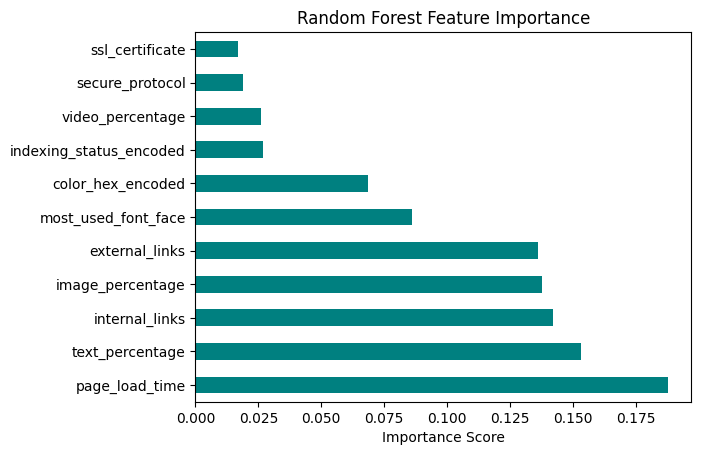

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X_for_analysis, y)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for plotting
feat_importances = pd.Series(importances, index=X_for_analysis.columns)

# Plot the feature importances
feat_importances.sort_values(ascending=False).plot(kind='barh', color='teal')
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.show()


In [96]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# # Exclude unnecessary columns
# columns_to_exclude = ['label', 'url', 'ssl_issuer', 'ssl_subject', 'ssl_not_before', 'ssl_not_after', 'domain']
# X = dataframe.drop(columns=columns_to_exclude)
# y = dataframe['label']

# Initialize RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Initialize Boruta
boruta_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    verbose=2,
    random_state=42
)

# Fit Boruta
boruta_selector.fit(X_for_analysis.values, y)

import numpy as np

# Get selected features
selected_features = X_for_analysis.columns[boruta_selector.support_].tolist()
print("Selected features (Boruta):", selected_features)

# Get tentative features
tentative_features = X_for_analysis.columns[boruta_selector.ranking_ > 1].tolist()
print("Tentative features:", tentative_features)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	6


BorutaPy

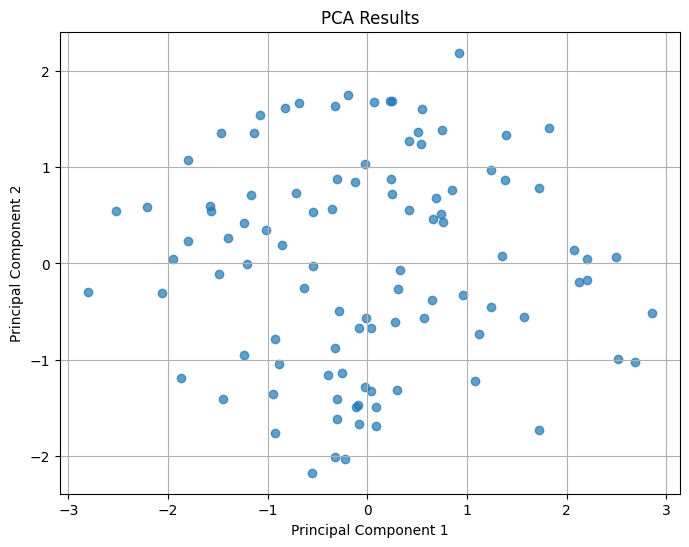

Explained variance by each component: [0.29005782 0.23214006]


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Sample DataFrame (replace this with your actual data)
# dataframe = pd.read_csv('your_data.csv')
# X = dataframe.drop(columns=['label'])  # Exclude the target variable if necessary

# For demonstration, let's create some synthetic data
np.random.seed(42)
X_for_analysis = np.random.rand(100, 5)  # 100 samples, 5 features

# Step 1: Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_for_analysis)

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_standardized)

# Step 3: Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])

# Optional: Add a target variable for coloring (if applicable)
# pca_df['label'] = dataframe['label']  # Uncomment if you have a label

# Step 4: Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], alpha=0.7)
plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Step 5: Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)



## Started with Analysis

In this notebook, we have performed various feature selection techniques to identify the most important features from our dataset. Below is a summary of the steps and methods used:

1. **Data Preparation**:
    - Loaded the dataset and excluded unnecessary columns.
    - Extracted RGBA values from color strings and converted them to hex format.
    - Applied label encoding to categorical features.

2. **Feature Selection Methods**:
    - **Mutual Information**: Used `mutual_info_classif` to compute the importance of each feature.
    - **Chi-square Test**: Applied `SelectKBest` with `chi2` to select the top features.
    - **Fisher’s Score**: Used `SelectKBest` with `f_classif` to rank features based on ANOVA F-value.
    - **Correlation Coefficient**: Computed the correlation matrix and visualized it using a heatmap.
    - **Variance Threshold**: Applied `VarianceThreshold` to remove features with low variance.
    - **Mean Absolute Difference (MAD)**: Calculated MAD for each feature and plotted the results.
    - **Dispersion Ratio**: Computed and plotted the dispersion ratio for each feature.
    - **Sequential Feature Selector**: Used forward feature selection with `SequentialFeatureSelector`.
    - **Recursive Feature Elimination (RFE)**: Applied RFE with `LogisticRegression` and `DecisionTreeClassifier`.
    - **LASSO Regularization**: Used `LassoCV` to select features based on L1 regularization.
    - **Random Forest**: Computed feature importances using `RandomForestClassifier`.
    - **Boruta**: Applied `BorutaPy` for feature selection using a random forest model.
    - **Exhaustive Feature Selector**: Used `ExhaustiveFeatureSelector` to evaluate all possible feature combinations.

3. **Dimensionality Reduction**:
    - **PCA**: Applied Principal Component Analysis to reduce the dimensionality of the dataset and visualize the results.

Each method provided insights into the importance of different features, helping us to identify the most relevant ones for our analysis.


In [103]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score

results_df = pd.DataFrame(columns=['Method', 'Important Features'])

results=[]

In [104]:
# 1. Information Gain
mi = mutual_info_classif(X_for_analysis, y)
mi_features = X_for_analysis.columns[mi > 0].tolist()
print({'Method': 'Information Gain', 'Important Features': mi_features})
results.append({'Method': 'Information Gain', 'Important Features': mi_features})

# 2. Chi-Square Test
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_for_analysis, y)
chi2_features = X_for_analysis.columns[chi2_selector.get_support()].tolist()
print({'Method': 'Chi-square Test', 'Important Features': chi2_features})
results.append({'Method': 'Chi-square Test', 'Important Features': chi2_features})

# 3. Random Forest Importance
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
rf.fit(X_for_analysis, y)
rf_importances = rf.feature_importances_
rf_features = X_for_analysis.columns[rf_importances > 0].tolist()
print({'Method': 'Random Forest Importance', 'Important Features': rf_features})
results.append({'Method': 'Random Forest Importance', 'Important Features': rf_features})

# 4. Lasso Regularization
lasso = Lasso(alpha=0.1)
lasso.fit(X_for_analysis, y)
lasso_features = X_for_analysis.columns[lasso.coef_ != 0].tolist()
print({'Method': 'Lasso Regularization', 'Important Features': lasso_features})
results.append({'Method': 'Lasso Regularization', 'Important Features': lasso_features})

# 5. Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
rfe.fit(X_for_analysis, y)
rfe_features = X_for_analysis.columns[rfe.support_].tolist()
print({'Method': 'Recursive Feature Elimination', 'Important Features': rfe_features})
results.append({'Method': 'Recursive Feature Elimination', 'Important Features': rfe_features})

# 6. Boruta
boruta_selector = BorutaPy(
    estimator=RandomForestClassifier(n_jobs=-1),
    n_estimators='auto',
    random_state=42
)
boruta_selector.fit(X_for_analysis.values, y)
boruta_features = X_for_analysis.columns[boruta_selector.support_].tolist()
results.append({'Method': 'Boruta', 'Important Features': boruta_features})

# 7. Principal Component Analysis (PCA)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_for_analysis)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_standardized)
pca_features = [f'PC{i+1}' for i in range(X_pca.shape[1])]
results.append({'Method': 'PCA', 'Important Features': pca_features})

# 8. Forward Feature Selection
def forward_selection(X, y):
    selected_features = []
    remaining_features = list(X.columns)
    while remaining_features:
        best_feature = None
        best_score = -np.inf
        for feature in remaining_features:
            score = mutual_info_score(y, X[feature])
            if score > best_score:
                best_score = score
                best_feature = feature
        if best_feature is None:
            break
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    return selected_features

fs_features = forward_selection(X_for_analysis, y)
results.append({'Method': 'Forward Feature Selection', 'Important Features': fs_features})

# # 9. Backward Feature Elimination
# def backward_elimination(X, y):
#     features = list(X.columns)
#     while len(features) > 0:
#         scores = []
#         for feature in features:
#             X_temp = X.drop(columns=feature)
#             score = mutual_info_score(y, X_temp)
#             scores.append(score)
#         worst_feature = features[np.argmin(scores)]
#         features.remove(worst_feature)
#     return features

# be_features = backward_elimination(X_for_analysis, y)
# results.append({'Method': 'Backward Feature Elimination', 'Important Features': be_features})



# 9. Backward Feature Elimination
def backward_elimination(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=1000)

    # Backward Feature Elimination
    selector = RFE(model, n_features_to_select=8, step=1)
    selector.fit(X_scaled, y)

    # Get selected feature indices
    selected_mask = selector.support_
    selected_features = X_for_analysis.columns[selected_mask]

    # Print selected features
    return  selected_features.tolist()


# Use the function
be_features = backward_elimination(X_for_analysis, y)
results.append({'Method': 'Backward Feature Elimination', 'Important Features': be_features})




{'Method': 'Information Gain', 'Important Features': ['page_load_time', 'most_used_font_face', 'image_percentage', 'video_percentage', 'text_percentage', 'internal_links', 'external_links', 'ssl_certificate', 'color_hex_encoded', 'indexing_status_encoded']}
{'Method': 'Chi-square Test', 'Important Features': ['page_load_time', 'most_used_font_face', 'image_percentage', 'video_percentage', 'text_percentage', 'internal_links', 'external_links', 'ssl_certificate', 'secure_protocol', 'color_hex_encoded', 'indexing_status_encoded']}
{'Method': 'Random Forest Importance', 'Important Features': ['page_load_time', 'most_used_font_face', 'image_percentage', 'video_percentage', 'text_percentage', 'internal_links', 'external_links', 'ssl_certificate', 'secure_protocol', 'color_hex_encoded', 'indexing_status_encoded']}
{'Method': 'Lasso Regularization', 'Important Features': ['page_load_time', 'most_used_font_face', 'image_percentage', 'text_percentage', 'internal_links', 'external_links', 'color_

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarni

In [105]:
results_df = pd.DataFrame(results)
print(results_df)

                          Method  \
0               Information Gain   
1                Chi-square Test   
2       Random Forest Importance   
3           Lasso Regularization   
4  Recursive Feature Elimination   
5                         Boruta   
6                            PCA   
7      Forward Feature Selection   
8   Backward Feature Elimination   

                                  Important Features  
0  [page_load_time, most_used_font_face, image_pe...  
1  [page_load_time, most_used_font_face, image_pe...  
2  [page_load_time, most_used_font_face, image_pe...  
3  [page_load_time, most_used_font_face, image_pe...  
4  [page_load_time, image_percentage, text_percen...  
5  [page_load_time, image_percentage, text_percen...  
6                          [PC1, PC2, PC3, PC4, PC5]  
7  [page_load_time, text_percentage, image_percen...  
8  [page_load_time, image_percentage, video_perce...  


In [106]:
results_df.to_csv('feature_selection_results.csv', index=False)